In [9]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from scipy.stats import truncnorm


In [8]:
def load_data():
  X =np.load('data2D.npy')
  valid_batch = int(len(X) / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(len(X))
  np.random.shuffle(rnd_idx)
  val_data = X[rnd_idx[:valid_batch]]
  data = X[rnd_idx[valid_batch:]]

  return data, val_data



In [7]:
def truncated_normal(size, threshold=1):
  # This function generates a truncated normal distribution
  values = truncnorm.rvs(-threshold, threshold, size=size)
  return values

In [6]:
def distanceFunc(X, MU):
  #TODO: explain this function in your report
  X1 = torch.unsqueeze(X, -1)
  MU1 = torch.unsqueeze(MU.T, 0)

  pair_dist = torch.sum((X1 - MU1)**2, 1)
  return pair_dist


In [5]:
def log_GaussPDF(X, mu, sigma):
  #TODO: explain this function in your report
  dim = X.shape[-1]

  Pi = torch.tensor(float(np.pi))
  sigma_2 = (torch.square(sigma)).T # 1 X K
  diff = distanceFunc(X, mu)  # N X K

  log_PDF = diff / sigma_2  # N X K
  log_PDF += dim * torch.log(2 * Pi)
  log_PDF += dim * torch.log(sigma_2)
  log_PDF *= -0.5  # N X K

  return log_PDF



In [4]:
def log_posterior(log_PDF, log_pi):
  #TODO: Explain this function in your report
  log_joint = log_PDF + log_pi.T  # N X K
  log_marginal = torch.logsumexp(log_joint,dim=1)  # N x 1

  return log_joint, log_marginal



In [3]:
def train_gmm(train_data, test_data, k = 5, epoch=1000, init_kmeans=False):
  #Load the data
  X_train = torch.from_numpy(train_data)
  X_test = torch.from_numpy(test_data)

  #Initialize logits
  if init_kmeans:
    logits = torch.ones(k, requires_grad=True)
    kmeans = KMeans(n_clusters=k, max_iter=5000).fit(train_data)
    mu = torch.tensor(kmeans.cluster_centers_, requires_grad=True)
    lr = 0.005
  else:
    logits = torch.rand(k, requires_grad=True)
    mu = torch.randn((k,X_train.shape[1]), requires_grad=True)
    lr = 0.005

  #Initialize sigma.
  sigma = np.abs(truncated_normal((k,1), threshold=1))
  sigma = torch.tensor(sigma,requires_grad=True)
  optimizer = torch.optim.Adam([logits, mu, sigma], lr=lr,
                                betas=(0.9, 0.99), eps=1e-5)
  #Train the model
  for i in range(epoch):
    logpi = F.log_softmax(logits)

    #TODO: Compute log likelihood per cluster and marginal likelihood for the whole mixture.
    # Fill in the blank (2lines below) of the functions log_GaussPDF and log_posterior
    log_PDF = log_GaussPDF(X_train, mu, sigma) #fill in here
    _, log_marginal = log_posterior(log_PDF, logpi) #fill in here

    #Compute the marginal mean.
    loss = -log_marginal.mean()

    #Update the paramenters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  #Perform on Test data
  logpi = F.log_softmax(logits)

  #TODO: Evaluate on Test Set. Fill in the blank of the functions
  # log_GaussPDF and log_posterior
  log_PDF = log_GaussPDF(X_test, mu, sigma) #fill in here
  log_joint_test, log_marginal = log_posterior(log_PDF, logpi) #fill in here
  test_loss = -log_marginal.mean()

  #Conver to numpy:
  test_loss = test_loss.detach().numpy()
  log_joint_test = log_joint_test.detach().numpy()
  pi = torch.exp(logpi).detach().numpy()
  mu = mu.detach().numpy()
  sigma = sigma.detach().numpy()

  return test_loss, log_joint_test, pi, mu, sigma



In [14]:
def test_GMM(k = 5, init_kmeans=False):
  train_data, test_data = load_data()
  test_loss, log_joint_test, pi, mu, sigma = train_gmm(train_data, test_data, k, init_kmeans=init_kmeans)

  index = log_joint_test.argmax(axis=1)
  index = index.reshape(len(index), 1)
  new_X = np.concatenate((test_data, index), axis = 1)

  color_list = ['g', 'b', 'm', 'y', 'c']
  for i in range(len(mu)):
    tmp = new_X[new_X[...,-1] == i]
    plt.scatter(tmp[:,0], tmp[:,1], c=color_list[i])
  plt.scatter(mu[:,0], mu[:,1], s=300, c='r', marker = '+')
  plt.show()


<ipython-input-3-fa8df105dccb>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)
<ipython-input-3-fa8df105dccb>:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)


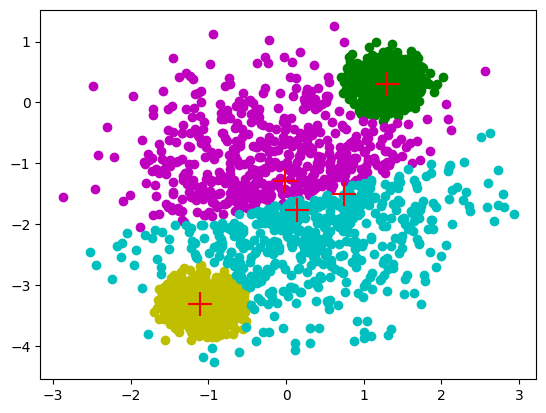

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-fa8df105dccb>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)
<ipython-input-3-fa8df105dccb>:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)


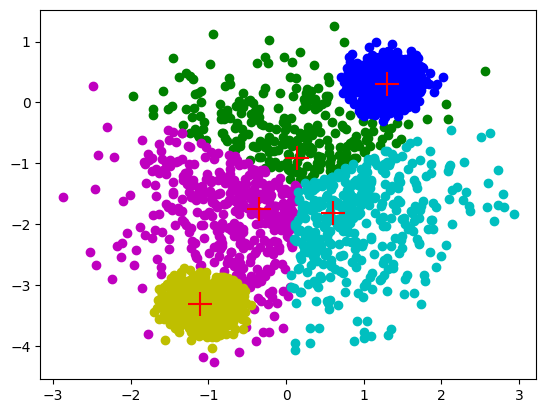

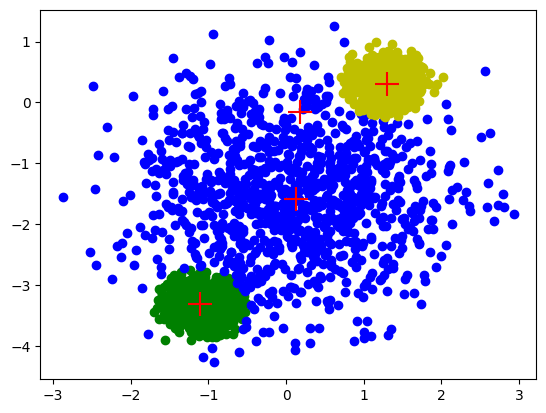

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-fa8df105dccb>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)
<ipython-input-3-fa8df105dccb>:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)


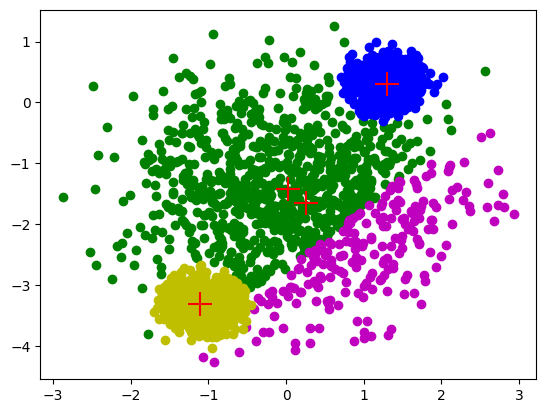

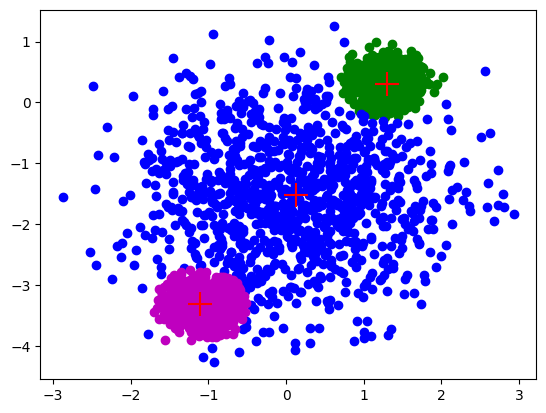

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-fa8df105dccb>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)
<ipython-input-3-fa8df105dccb>:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)


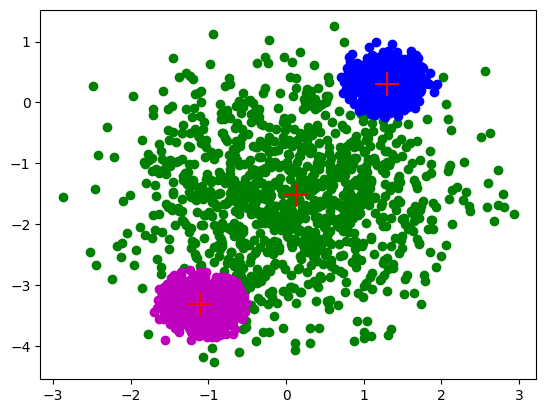

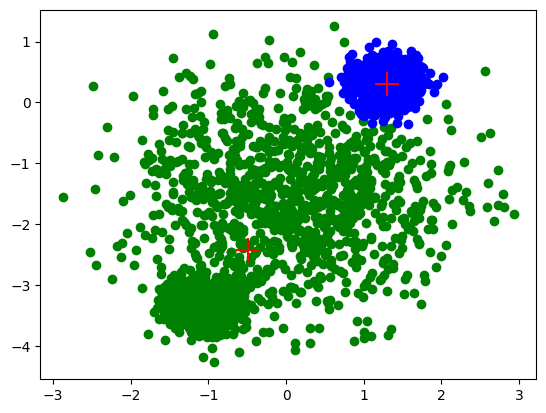

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-fa8df105dccb>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)
<ipython-input-3-fa8df105dccb>:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)


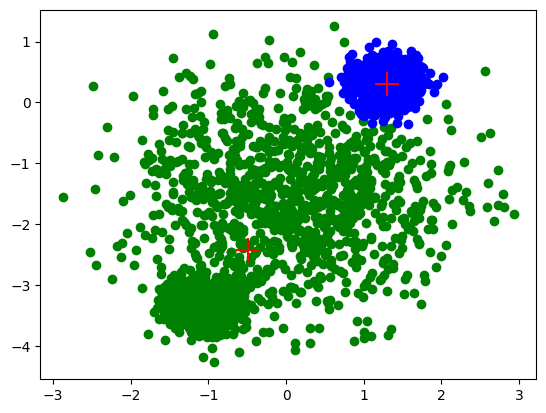

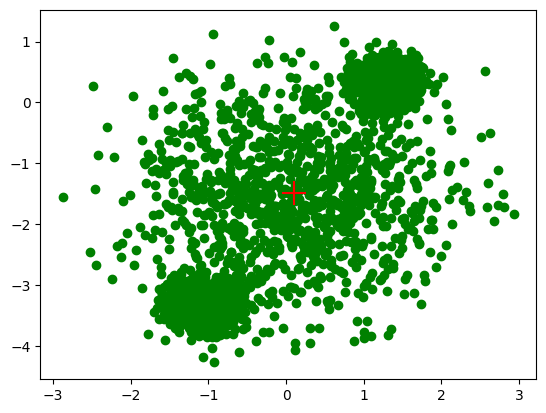

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-fa8df105dccb>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)
<ipython-input-3-fa8df105dccb>:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)


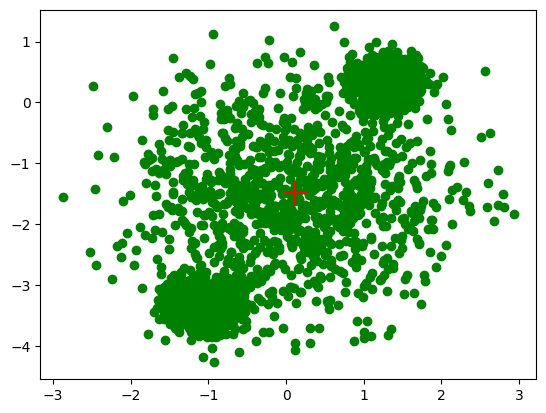

In [15]:
for i in range(5, 0, -1):
  sign = False
  test_GMM(i,sign)
  sign = True
  test_GMM(i,sign)




<ipython-input-3-fa8df105dccb>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)
<ipython-input-3-fa8df105dccb>:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpi = F.log_softmax(logits)


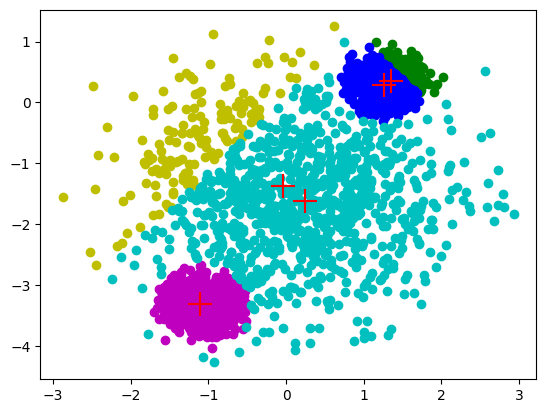

In [19]:
test_GMM(5,False)